# Dificuldades de analisar outros países

Esse pequeno texto tenta explicar as ducidades que venho enfrentando ao analisar os dados 
de outros países quando uso o Robot Dance com testes. Para isso temos que enteder uma premissa
básica do nosso modelo e as consequências dela:
    
**Os testes só são feitos quando pessoas com sintomas se apresentam. Não há nenhum tipo de 
rastreamento de contatos no modelo.**

Essa premissa permeia algumas decisões e hipóteses:
    
1. A cada 4 pessoas que se apresentam para fazer testagem apenas 1 tem Covid-19.

2. Apenas 40\% das pessoas se apresentam para testagem (se entendo bem isso tenta modelar
   a maior parte dos doentes é assintomático).

3. Assim o número máximo de testes feitos por dia é $4 \cdot 0.4 \cdot$ número de novos 
   doentes do dia. Ou seja o máximo de testes é de cerca de $1.6 \cdot$ nº de novos doentes.
   
Tenho tentado nos últimos tempos fazer análises do tipo

**O que ocorre se tivéssemos usado o Robot Dance para ajudar o número de testes na Alemanha ou
na cidade de Nova York?**

Entendo que a ideia é comparar o que foi de fato feito no passado com o que teria ocorrido se esses
lugares tivessem usado o Robot Dance.

Para fazer isso preciso separar, a partir dos dados históricos, o efeito do distanciamento social e dos testes realizados em cada um desses lugares. Para isso pensei em adotar a seguinte estratégia,
fixando inicialmente uma janela de tempo no qual será feita a análise. 

1. Faço um ajuste inicial dos dados tentando levantar qual foi a evolução do R0 no tempo descontando
o efeito dos testes. Para conseguir isso pensei em fixar no Robot Dance o número de testes feitos. Como ele simula o efeito desses testes essa seria uma forma de descontar o seu efeito.

2. O resultado obtido seria então uma curva do R0 em um período do tempo que iria representar o efeito
do distanciamento social sem testes. Também posso usar o total de testes realizados no período como um orçamento de testes que o Robot Dance pode distribuir de forma inteligente. 

3. Fixo então esse R0 e peço para o Robot Dance definir quantos testes devem ser feitos para se atingir o objetivo desejado. Por exemplo para minimizar o número de doentes, ou evitar a sobrecarga
do sistema de UTIs.

Até aqui tudo bem. Mas então vemos um problema: para que o ítem (1) acima seja bem sucedido é preciso que a região não tenha realizado rastreamento de contatos, já que isso não está modelado no Robot Dance. Note que (1) é condiaçao para fazer (2) e (3), então é fundamental fazer isso e fazer isso com confiança que estamos fazendo tudo corretamente. Notem que isso só ficou claro para mim a medida que fui fazendo testes e entendendo os dados. 

Uma das coisas que está clara para mim, por exemplo, é que não faz sentido rodar o Robot Dance se o orçamento de testes for consistentemente maior do que $1.6 \cdot$ número de doentes novos a cada dia. Isso porque esse é o número máximo que o Robot Dance vai usar e se ele tiver tudo isso disponível a cada dia, ou seja se não houver nenhum tipo de escassez, ele vai usar todos os testes porque eles só melhoram a situação (diminuem o número de doentes e com isso liberam mais UTIs). 

Essas observações liberaram de cara a Alemanha, já que ela usou sempre um grande número de testes por estar fazendo algum tipo de rastreamento de contato. Nos últimos tempos o rastreamento de contatos falhou, o número de testes é ainda alto sugerindo que ainda estão fazendo.

Daí veio a ideia de analisar os dados da cidade de Nova York. Mas de novo o número de testes feito é muito alto, sugerindo que algum tipo de rastreamento de contato está sendo feito. Seja o tradicional, ou seja simplesmente um número grande de pessoas procurando testes porque souberam que pessoas próximas ficaram doentes. Uma espécie de rastreamento de contatos "passivo". Vamos aos dados. 

A primeira figura abaixo mostra os número de novos casos diários e a média móvel de 7 dias. Isso considerando uma subnotificação de 10 sugerida em um artigo que a Claudia me mandou. Notem que mantive a subnotificação constante. E apesar de eu achar que o número 10 está OK para o começo tenebroso da pandemia lá, com o forte aumento no número de testes, não sei se é um valor razoável hoje em dia.

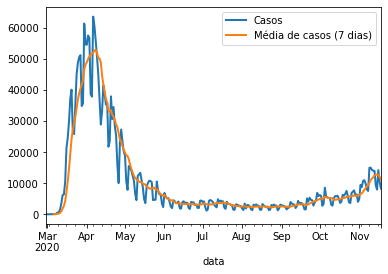

In [14]:
import pandas as pd
import matplotlib.pylab as plt

# Read data
trends = pd.read_csv("data-by-day.csv", parse_dates=["date_of_interest"])
trends["TOTAL_CASES"] = trends["CASE_COUNT"].cumsum()
trends["TOTAL_DEATHS"] = trends["DEATH_COUNT"].cumsum()
trends

# Convert to be used by vidas salvas

# Add fake columns 
trends["regiao"] = "US"
trends["estado"] = "NYC"

# Generate data for robot dance
data = trends[["estado", "date_of_interest", "TOTAL_CASES"]].copy()
pop = 8336817
data["estimated_population_2019"] = pop
data["icu_capacity"] = 4000/pop
data["state"] = "NJ"
data = data.rename(columns = {
    "estado": "city",
    "date_of_interest": "date",
    "TOTAL_CASES": "confirmed"
})
sub_factor = 10.0
data["confirmed"] *= sub_factor
data = data[data["date"] <= pd.to_datetime("2020-5-19")]
data.to_csv("nyc_robot_data.csv")
data = data[data["date"] <= pd.to_datetime("2020-4-14")]
data.to_csv("nyc_robot_data_start.csv")

# Generate data for Vidas Salvas
# Select data in the right order
data = trends[["regiao", "estado", "date_of_interest", "CASE_COUNT", "TOTAL_CASES", "DEATH_COUNT", "TOTAL_DEATHS"]]
data = data.rename(columns = {
    "date_of_interest": "data",
    "CASE_COUNT": "novos.casos",
    "TOTAL_CASES": "casos.acumulados",
    "DEATH_COUNT": "novos.obitos",
    "TOTAL_DEATHS": "obitos.acumulados"
})

# Adjust for the subnotification... This is risky...
data["novos.casos"] *= sub_factor
data["casos.acumulados"] *= sub_factor
data["novos.obitos"] *= sub_factor
data["obitos.acumulados"] *= sub_factor

# Save data
data.to_csv("nyc_vidas_salvas.csv", index=False)

# Add rolling average
window = 7
data["novos.casos.7d"] = data["novos.casos"].rolling(window).mean()

# Plot cases and rolling average
ax = plt.gca()
data.plot(x="data", y="novos.casos", label="Casos", lw=2, ax=ax)
data.plot(x="data", y="novos.casos.7d", label="Média de casos (7 dias)", lw=2, ax=ax);

Agora vamos ver o número de testes realizados diariamente, de novo os dados brutos e média móvel de 7
dias.

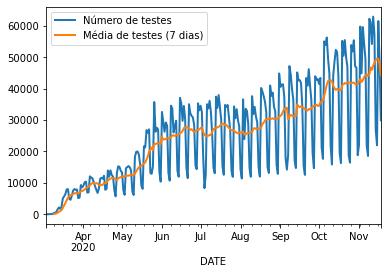

In [15]:
tests = pd.read_csv("tests.csv", parse_dates=["DATE"])
tests["TOTAL_TESTS_7D"] = tests["TOTAL_TESTS"].rolling(7).mean()

ax = plt.gca()
tests.plot(x="DATE", y="TOTAL_TESTS", lw=2, ax=ax, label="Número de testes")
tests.plot(x="DATE", y="TOTAL_TESTS_7D", lw=2, ax=ax, label="Média de testes (7 dias)");

Um primeiro comentário é que vemos que o número de testes tem aumentado de forma constante, mesmo no período que o número de casos estava baixo. Vamos agora ver a razão entre as médias do número de testes por doentes novos estimados.

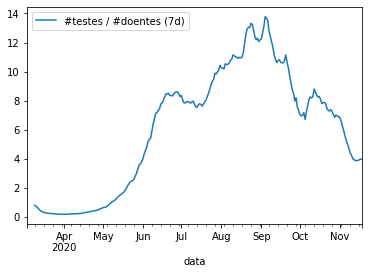

In [16]:
data = data[data["data"]>= pd.to_datetime("2020-03-03")]
test_ratio = pd.DataFrame({"data": data["data"], "Ratio": tests["TOTAL_TESTS_7D"].values/data["novos.casos.7d"].values})
test_ratio.plot(x="data", y="Ratio", label="#testes / #doentes (7d)");

O que vemos aí é que a partir de junho há um aumento forte no número de testes, passando do limiar de 1.6 testes por doente e a partir daí fazendo muito mais, em torno de 8 ou mais. Isso, para mim, sugere que está ocorrenedo algum tipo de rastremento de contato, seja ativo, seja passivo. vamos dar um zoom nesses dados até meados de maio

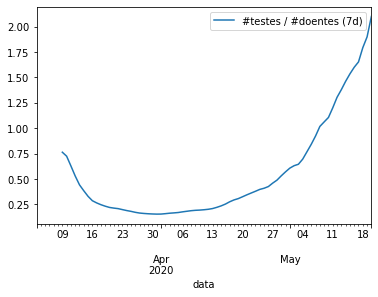

In [17]:
test_ratio = test_ratio[test_ratio["data"] <= pd.to_datetime("2020-05-20")]
test_ratio.plot(x="data", y="Ratio", label="#testes / #doentes (7d)");

Essa análise sugere que a única janela possível é fazer a análise em torno de 15 de março e 15 de maio.
A Claudia comentou que pode tentar ajustar a série temporal que estima o número de leitos usando o primeiro período (15/03 - 15/04) e fazemos a análise usando período seguinte de 15/04-15/05. 

É isso mesmo? Isso está razoável?

Obs: Algo que sugere que o resultado pode não ser tão interessante é que nesse período é o pico do distancimento social em NYC, como está sugerido no gráfico do RT abaixo. Isso sugere que o efeito dos testes disponíveis foi mínimo, o grosso do efeito estará no distanciamento que foi extremamente efetivo.

![RT em NYC](rt_nyc.png)

In [18]:
tests = pd.read_csv("tests.csv", parse_dates=["DATE"], index_col=[0])
tests

,TOTAL_TESTS,POSITIVE_TESTS,PERCENT_POSITIVE,TOTAL_TESTS_7DAYS_AVG,POSITIVE_TESTS_7DAYS_AVG,PERCENT_POSITIVE_7DAYS_AVG,INCOMPLETE
DATE,,,,,,,
2020-03-03,14,1,0.0714,NaN,NaN,NaN,NaN
2020-03-04,33,5,0.1515,NaN,NaN,NaN,NaN
2020-03-05,65,4,0.0615,NaN,NaN,NaN,NaN
2020-03-06,85,8,0.0941,NaN,NaN,NaN,NaN
2020-03-07,72,8,0.1111,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-11-14,26898,1167,0.0434,49015.0,1524.0,0.0311,68000.0
2020-11-15,21969,1005,0.0457,49503.0,1538.0,0.0311,68000.0
2020-11-16,61469,1691,0.0275,49398.0,1522.0,0.0308,68000.0


In [19]:
data = pd.read_csv("nyc_robot_data.csv", index_col=[0])
dates = data["date"]
selected_tests = []
for d in dates:
    try:
        selected_tests.append(tests.loc[d, "TOTAL_TESTS"] / pop)
    except KeyError:
        selected_tests.append(0)
selected_tests = pd.DataFrame(data={"date": dates, "tests": selected_tests})
selected_tests.to_csv("tests_robot_dance.csv", index=False)

In [7]:
#beds = pd.read_csv("beds.csv")
#beds